In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])

## RMSD Calculation

In [2]:
#Read all the trajectories
ku04amp02_pgl= mda.Universe('ku04amp02_pgl_complex/sys_prod/prod_ku04amp02_pgl_complex.tpr', 'ku04amp02_pgl_complex/sys_prod/prod_ku04amp02_pgl_complex_compact_compact.xtc')


  0%|          | 0/5001 [00:00<?, ?it/s]

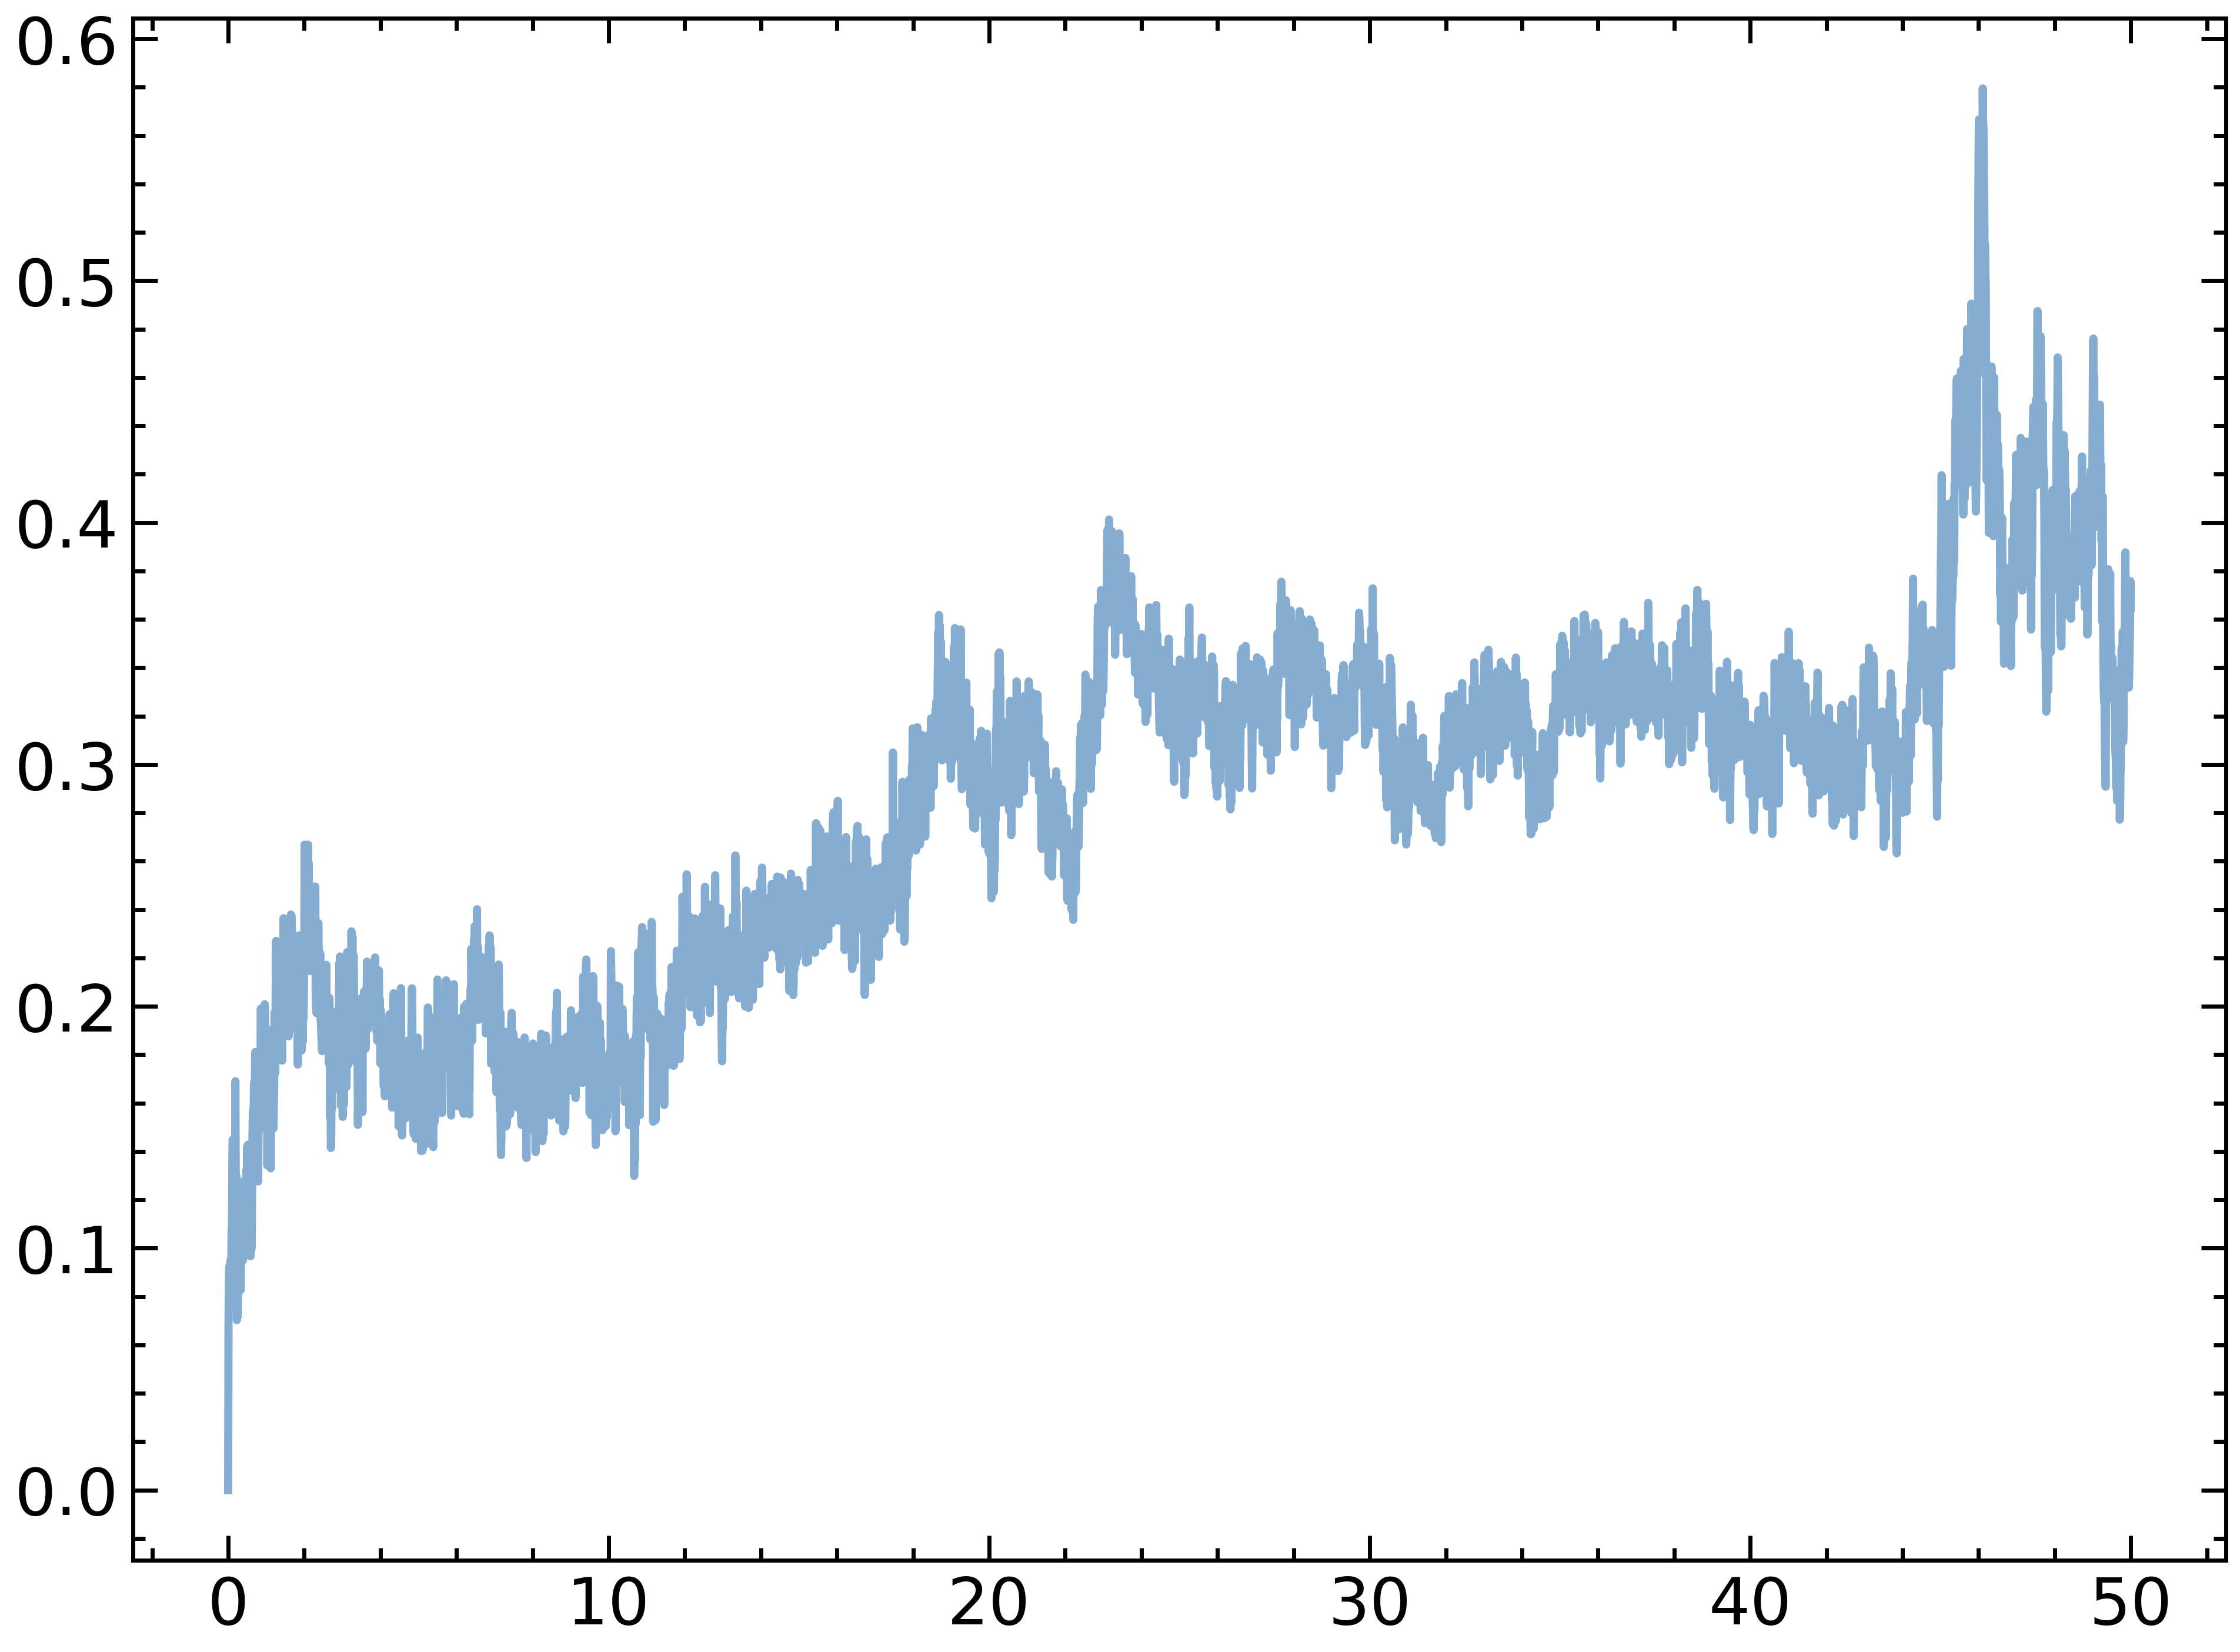

In [3]:
from MDAnalysis.analysis import rms

R = rms.RMSD(ku04amp02_pgl,  # universe to align
    ku04amp02_pgl,  # reference universe or atomgroup
    select='backbone',  # group to superimpose and calculate RMSD
    ref_frame=0)  # frame index of the reference

R.run(verbose=True)
times_c = R.results.rmsd[:,1]
rmsd_c = R.results.rmsd[:,2]
plt.plot(times_c/1000, rmsd_c/10, alpha=0.5)

## Radius of Gyration Calculation

  0%|          | 0/5001 [00:00<?, ?it/s]

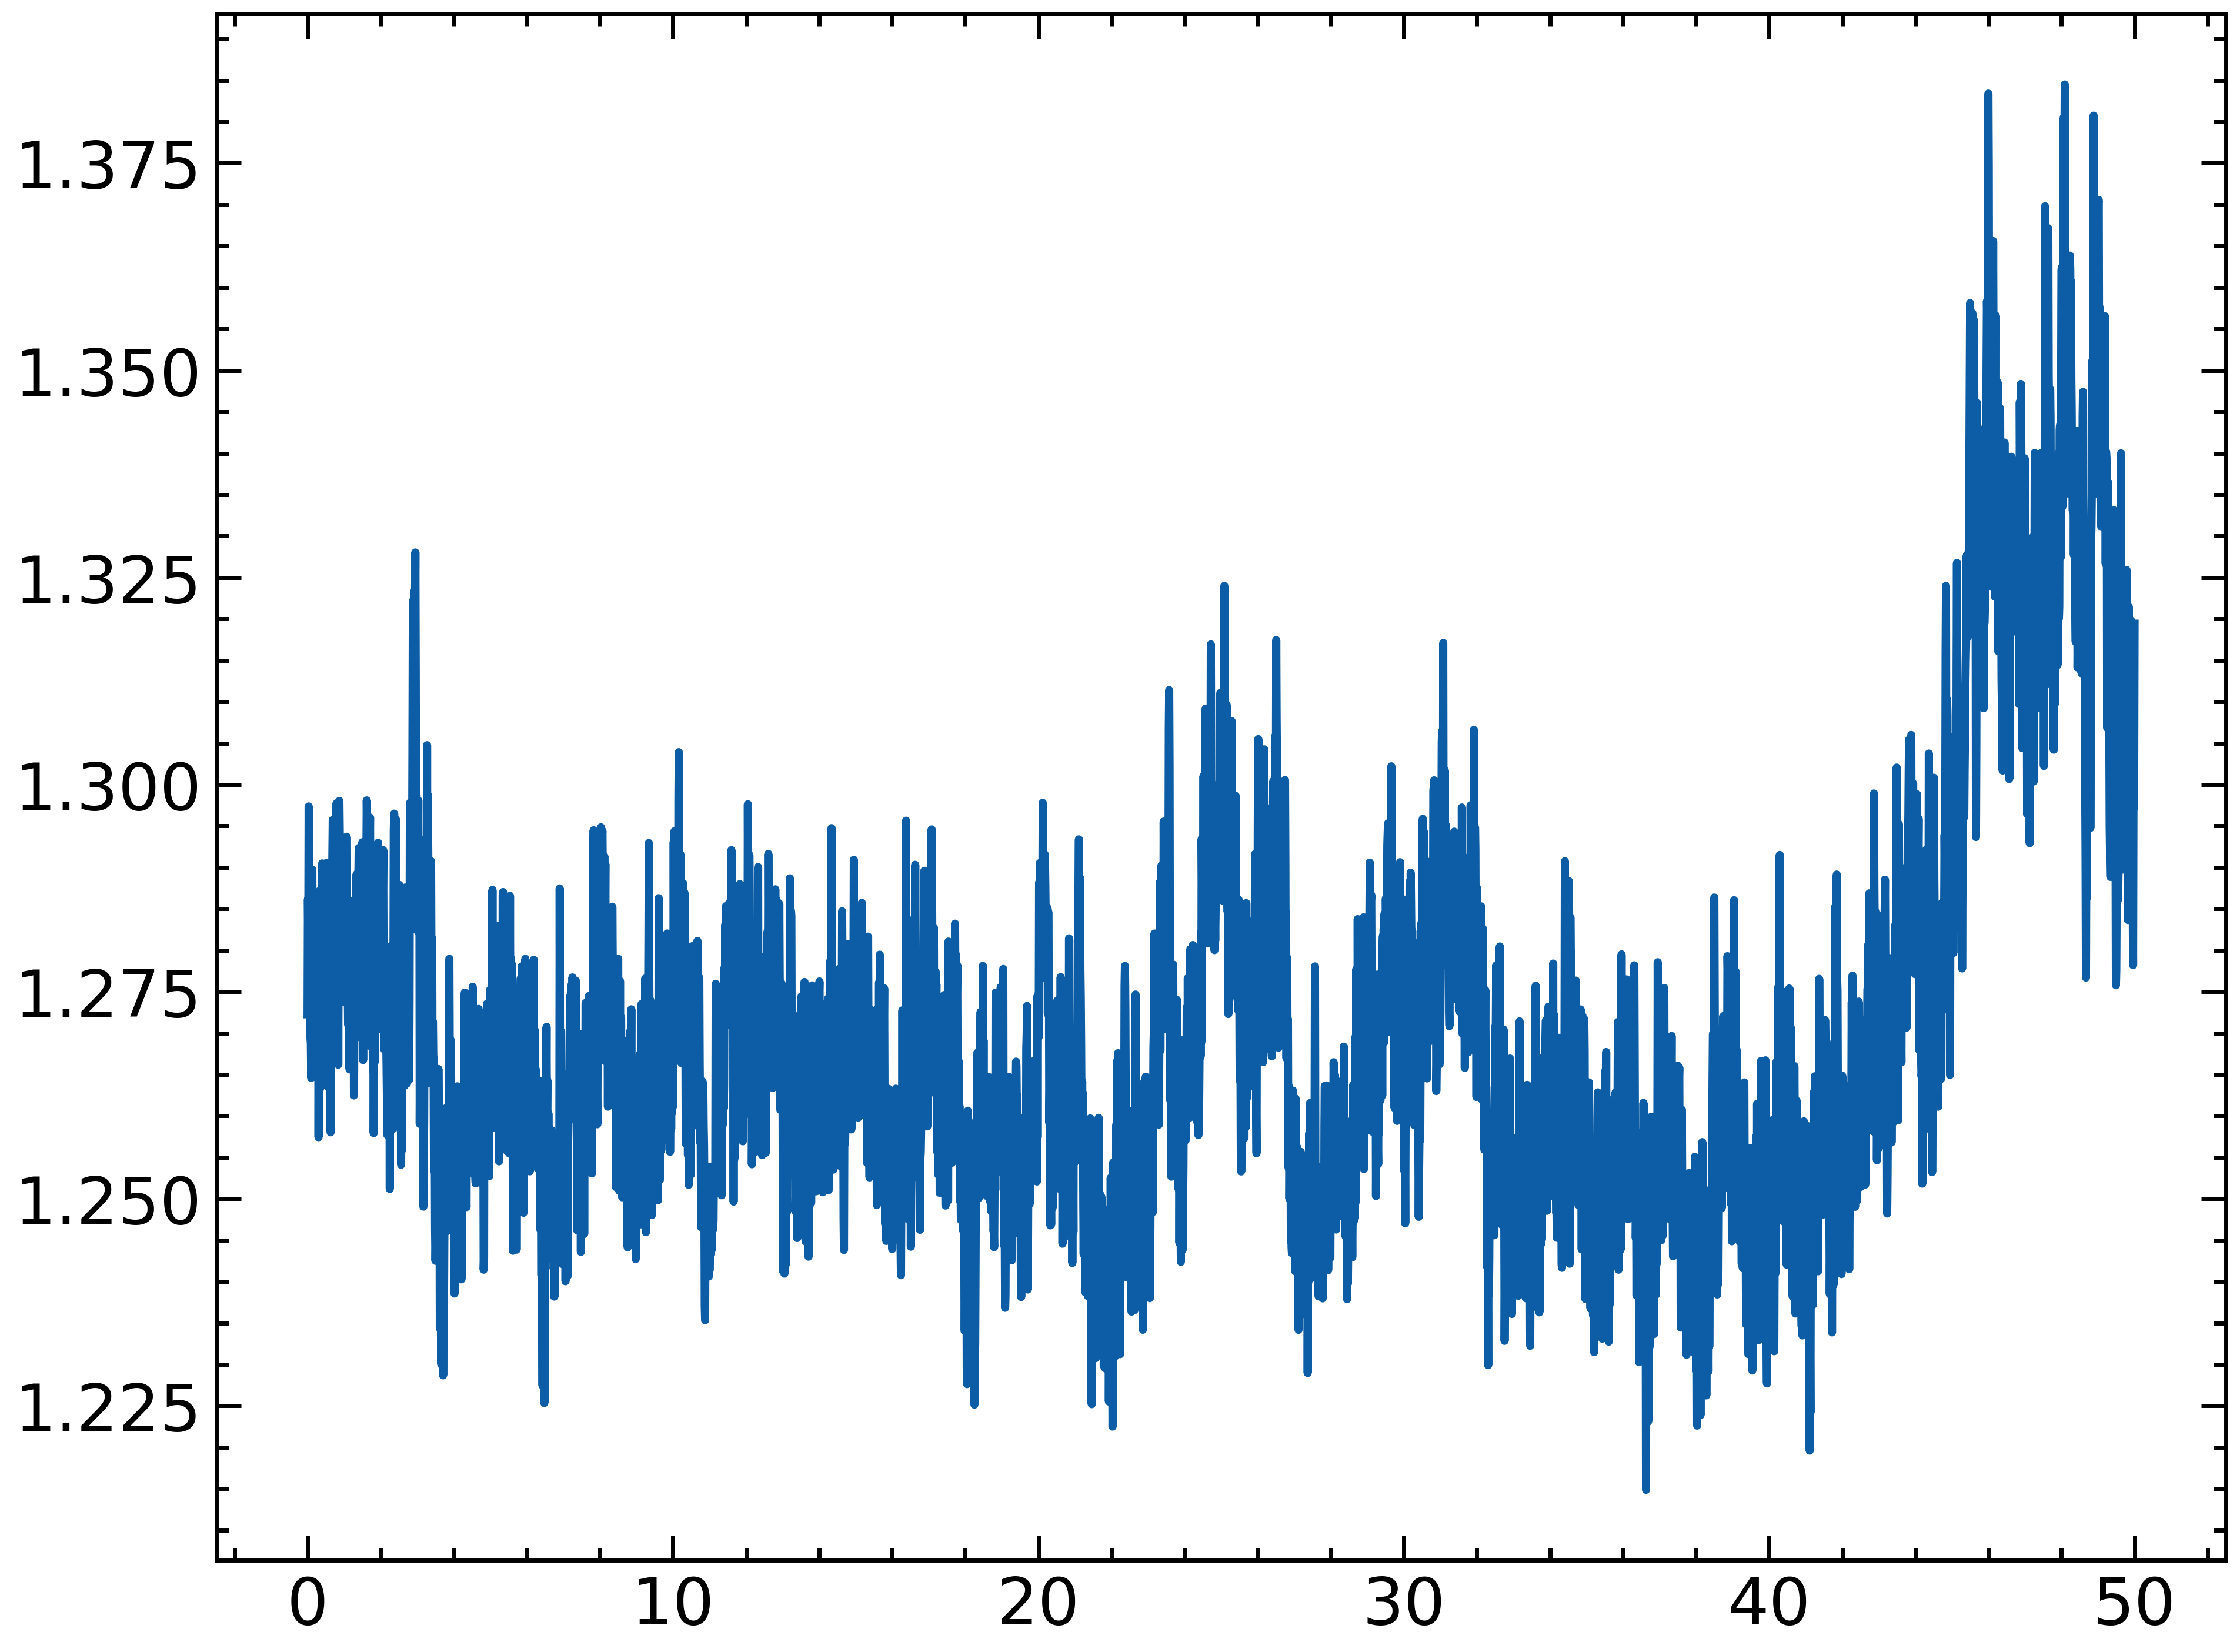

In [4]:
from tqdm.notebook import tqdm
group = ku04amp02_pgl.select_atoms('protein')		# change the atom selection for your specific system

Frame = []
times = []
Rgyr = []
for ts in tqdm(ku04amp02_pgl.trajectory):
	Frame.append(ts.frame)
	times.append(ku04amp02_pgl.trajectory.time)
	Rgyr.append(group.radius_of_gyration())

Rgyrc_table = np.vstack((Frame, times, Rgyr)).T
plt.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10)

## RMSF Calculation

Between protein backbone and Carbon alphas.

  0%|          | 0/5001 [00:00<?, ?it/s]

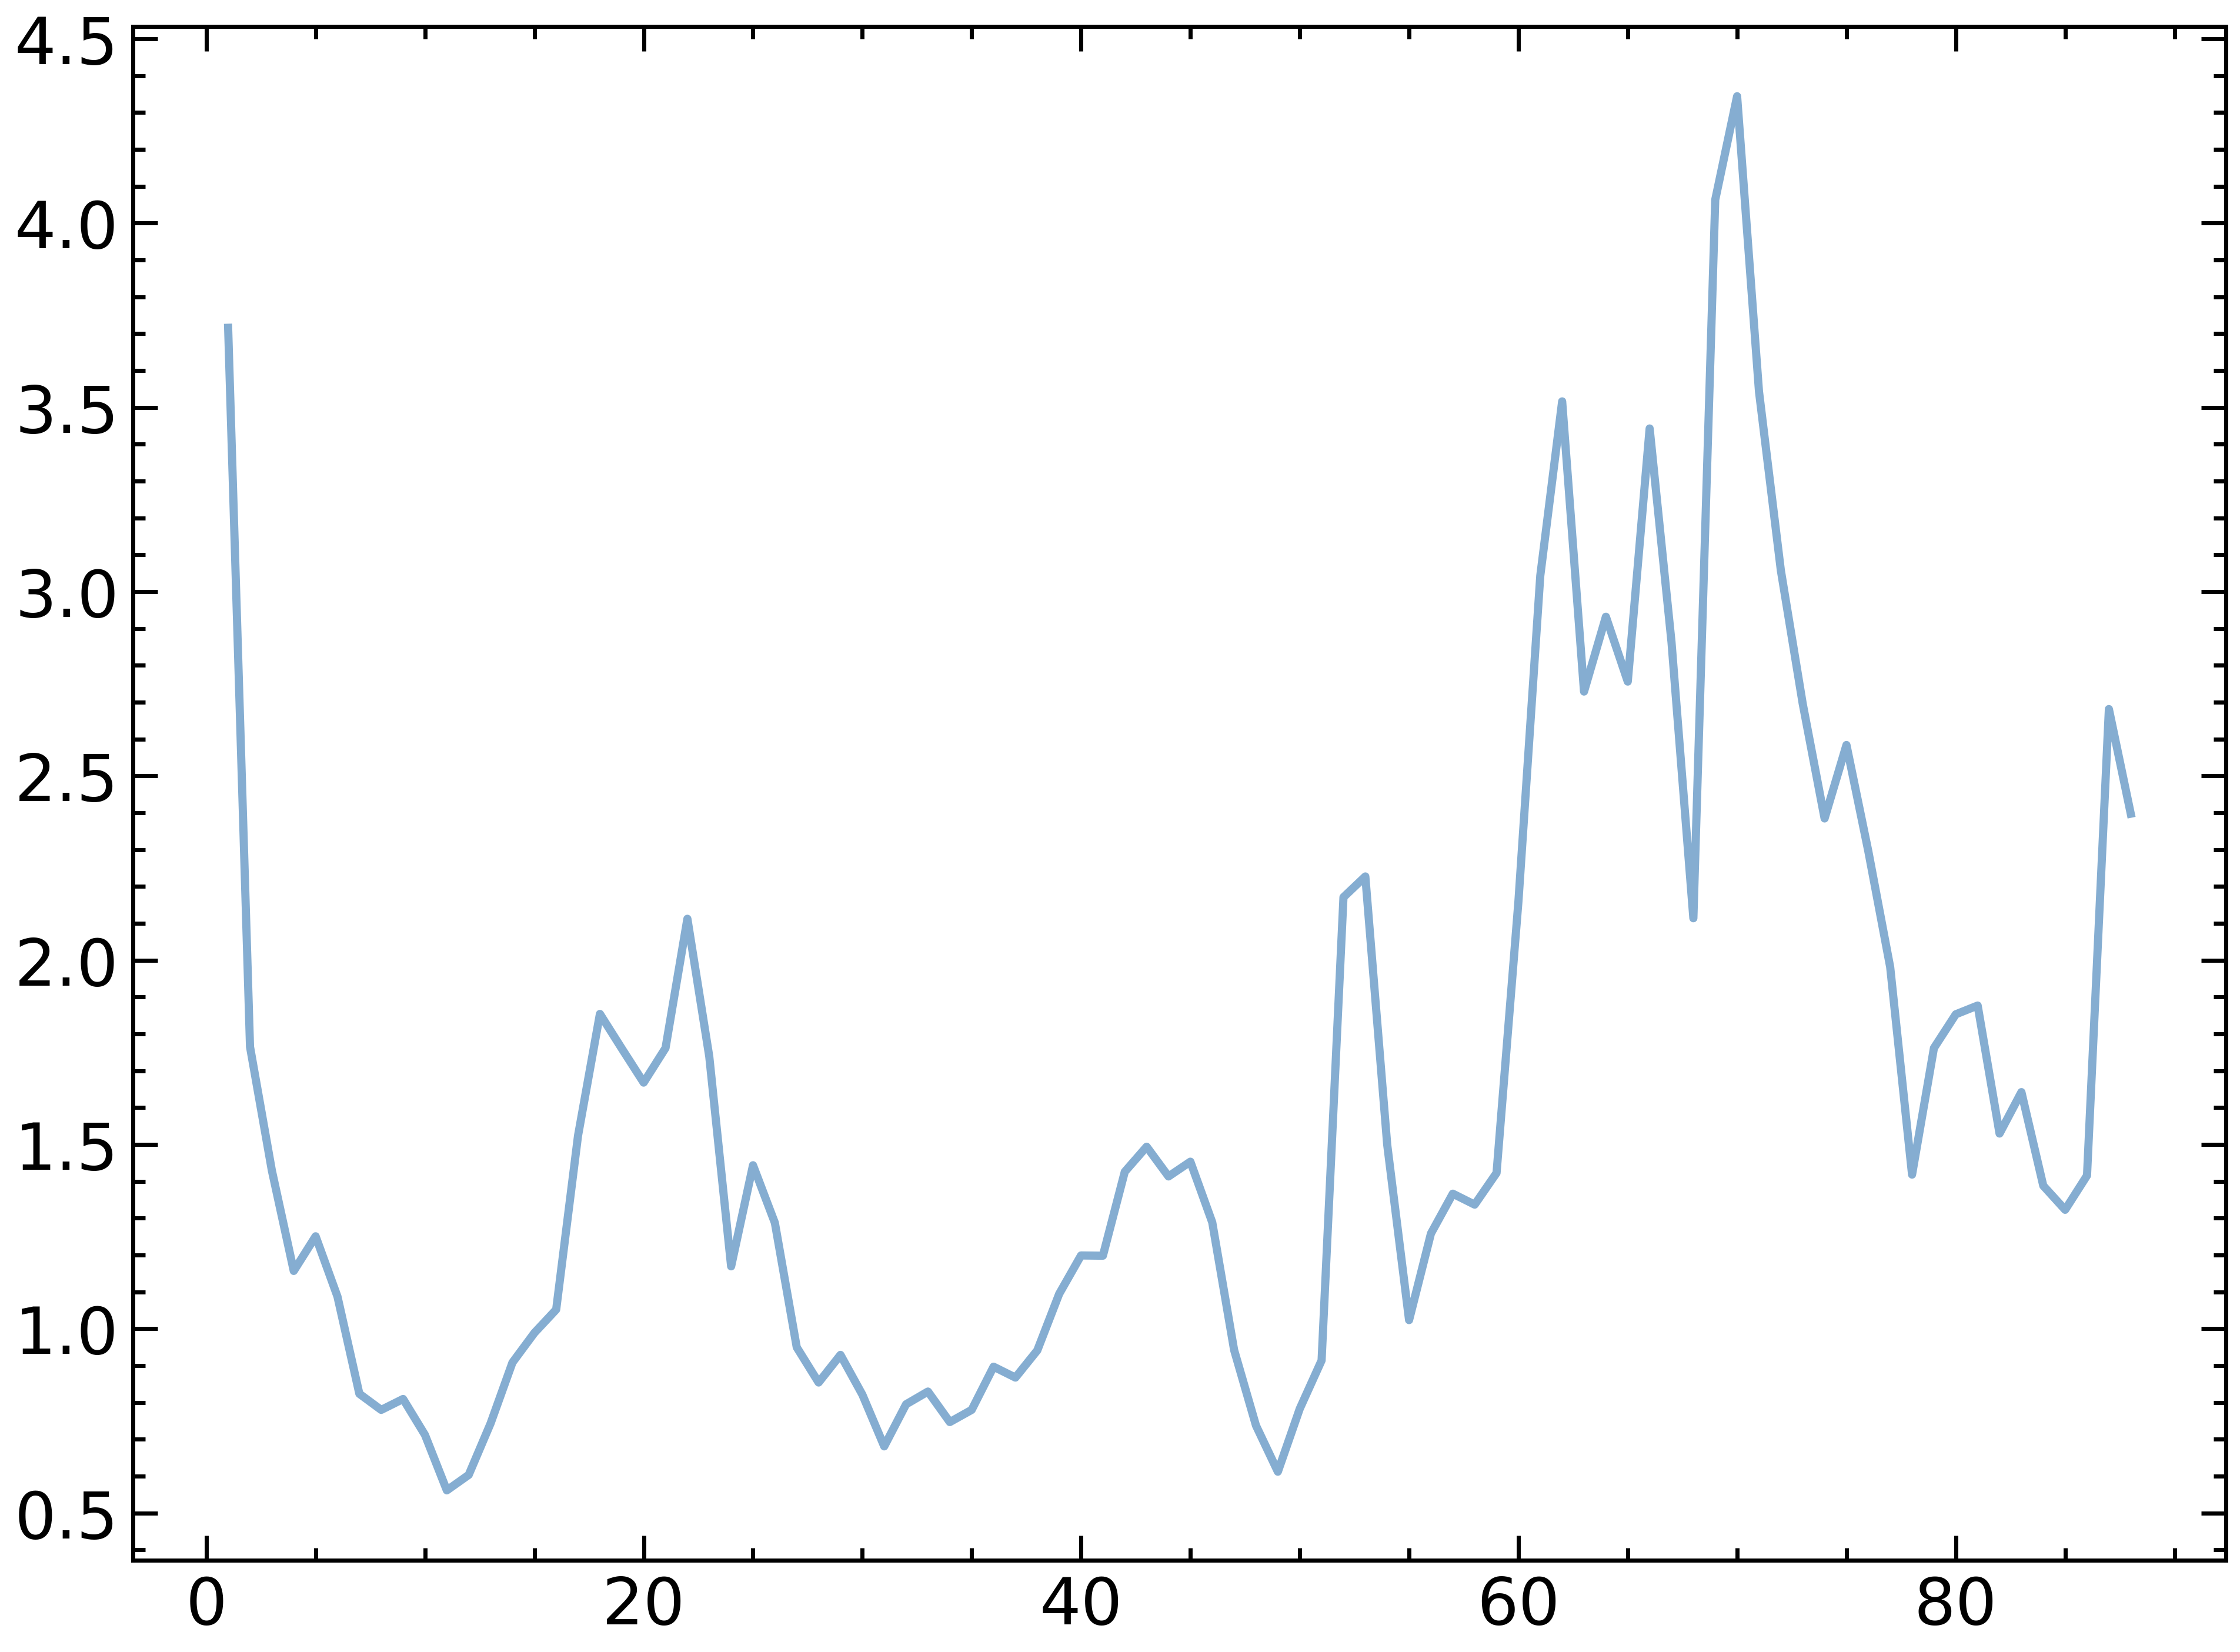

In [5]:
c_alphas_c = ku04amp02_pgl.select_atoms('backbone and name CA')
R_c = rms.RMSF(c_alphas_c).run(verbose=True)
plt.plot(c_alphas_c.resids, R_c.results.rmsf, alpha=0.5)

## H-bond analysis:

In [7]:
from MDAnalysis.analysis.hydrogenbonds.hbond_analysis import HydrogenBondAnalysis as HBA
import numpy as np
import pandas as pd
complexname = 'ku04amp02_pgl_complex'
universe = ku04amp02_pgl
    # Select the atoms for the analysis
    
    # Create the HydrogenBondAnalysis object
hbs = HBA(universe=universe,
          between=['resname PGL','protein'],
    update_selections=False
    )
protein_hydrogens_sel = hbs.guess_hydrogens("protein")
protein_acceptors_sel = hbs.guess_acceptors("protein")

lig_hydrogens_sel = hbs.guess_hydrogens("resname PGL")
lig_acceptors_sel = hbs.guess_acceptors("resname PGL")

hbs.hydrogens_sel = f"({protein_hydrogens_sel}) or ({lig_hydrogens_sel}"
hbs.acceptors_sel = f"({protein_acceptors_sel}) or ({lig_acceptors_sel}"
# Run the analysis

hbs.run(verbose=True)



  0%|          | 0/5001 [00:00<?, ?it/s]

/usr/local/miniforge3/envs/biobb_wf_protein-complex_md_setup/lib/python3.12/site-packages/MDAnalysis/analysis/hydrogenbonds/hbond_analysis.py:775: UserWarning: No hydrogen bonds were found given angle of 150 between Donor, None, and Acceptor, ((resname ALA and name O) or (resname ARG and name NE) or (resname ARG and name NH1) or (resname ARG and name NH2) or (resname ARG and name O) or (resname ASN and name ND2) or (resname ASN and name O) or (resname ASN and name OD1) or (resname ASP and name N) or (resname ASP and name O) or (resname ASP and name OD1) or (resname ASP and name OD2) or (resname CYX and name O) or (resname GLN and name NE2) or (resname GLN and name O) or (resname GLN and name OE1) or (resname GLU and name N) or (resname GLU and name O) or (resname GLU and name OE1) or (resname GLU and name OE2) or (resname GLY and name O) or (resname HID and name NE2) or (resname HID and name O) or (resname ILE and name O) or (resname LEU and name O) or (resname LEU and name OC1) or (re

In [9]:
hbs.count_by_type()

array([['ARG:N2', 'PGL:o', '40'],
       ['ARG:N2', 'PGL:oh', '4'],
       ['ASN:N', 'PGL:n8', '7'],
       ['ASN:N', 'PGL:oh', '59'],
       ['ASN:N', 'PGL:os', '5'],
       ['GLN:N', 'PGL:oh', '6'],
       ['LYS:N3', 'PGL:o', '41'],
       ['PGL:n8', 'ALA:O', '438'],
       ['PGL:n8', 'ARG:O', '81'],
       ['PGL:n8', 'ASN:N', '2'],
       ['PGL:n8', 'ASN:O', '75'],
       ['PGL:n8', 'ASP:O2', '6'],
       ['PGL:n8', 'GLN:O', '2'],
       ['PGL:n8', 'GLY:O', '3'],
       ['PGL:n8', 'HID:NB', '2'],
       ['PGL:n8', 'LEU:O', '1'],
       ['PGL:n8', 'LYS:O', '4'],
       ['PGL:n8', 'SER:O', '1'],
       ['PGL:n8', 'SER:OH', '1'],
       ['PGL:n8', 'TRP:O', '49'],
       ['PGL:n8', 'VAL:O', '7'],
       ['PGL:oh', 'GLN:O', '56'],
       ['PGL:oh', 'GLY:O', '23'],
       ['PGL:oh', 'VAL:O', '82'],
       ['SER:OH', 'PGL:o', '2'],
       ['SER:OH', 'PGL:oh', '1']], dtype='<U21')

In [11]:
from tqdm.notebook import tqdm
ligand_indices = universe.select_atoms('resname PGL').indices    
filtered_hbonds = []
for hb in tqdm(hbs.results.hbonds):
    frame, donor_idx, hydrogen_idx, acceptor_idx, da_dist, da_angle = hb
    if donor_idx not in ligand_indices and acceptor_idx in ligand_indices:
        filtered_hbonds.append(hb)
    if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
        filtered_hbonds.append(hb)
hbs.results.hbonds = np.array(filtered_hbonds)

times = hbs.times
nhb = hbs.count_by_time()
# For the first complex, initialize the DataFrame with the time column.

nhb_df = pd.DataFrame({'Time': times})
        
# Add the RMSD values for the current complex to the DataFrame.
nhb_df[complexname] = nhb
nhb_df.set_index('Time', inplace=True)

  0%|          | 0/998 [00:00<?, ?it/s]

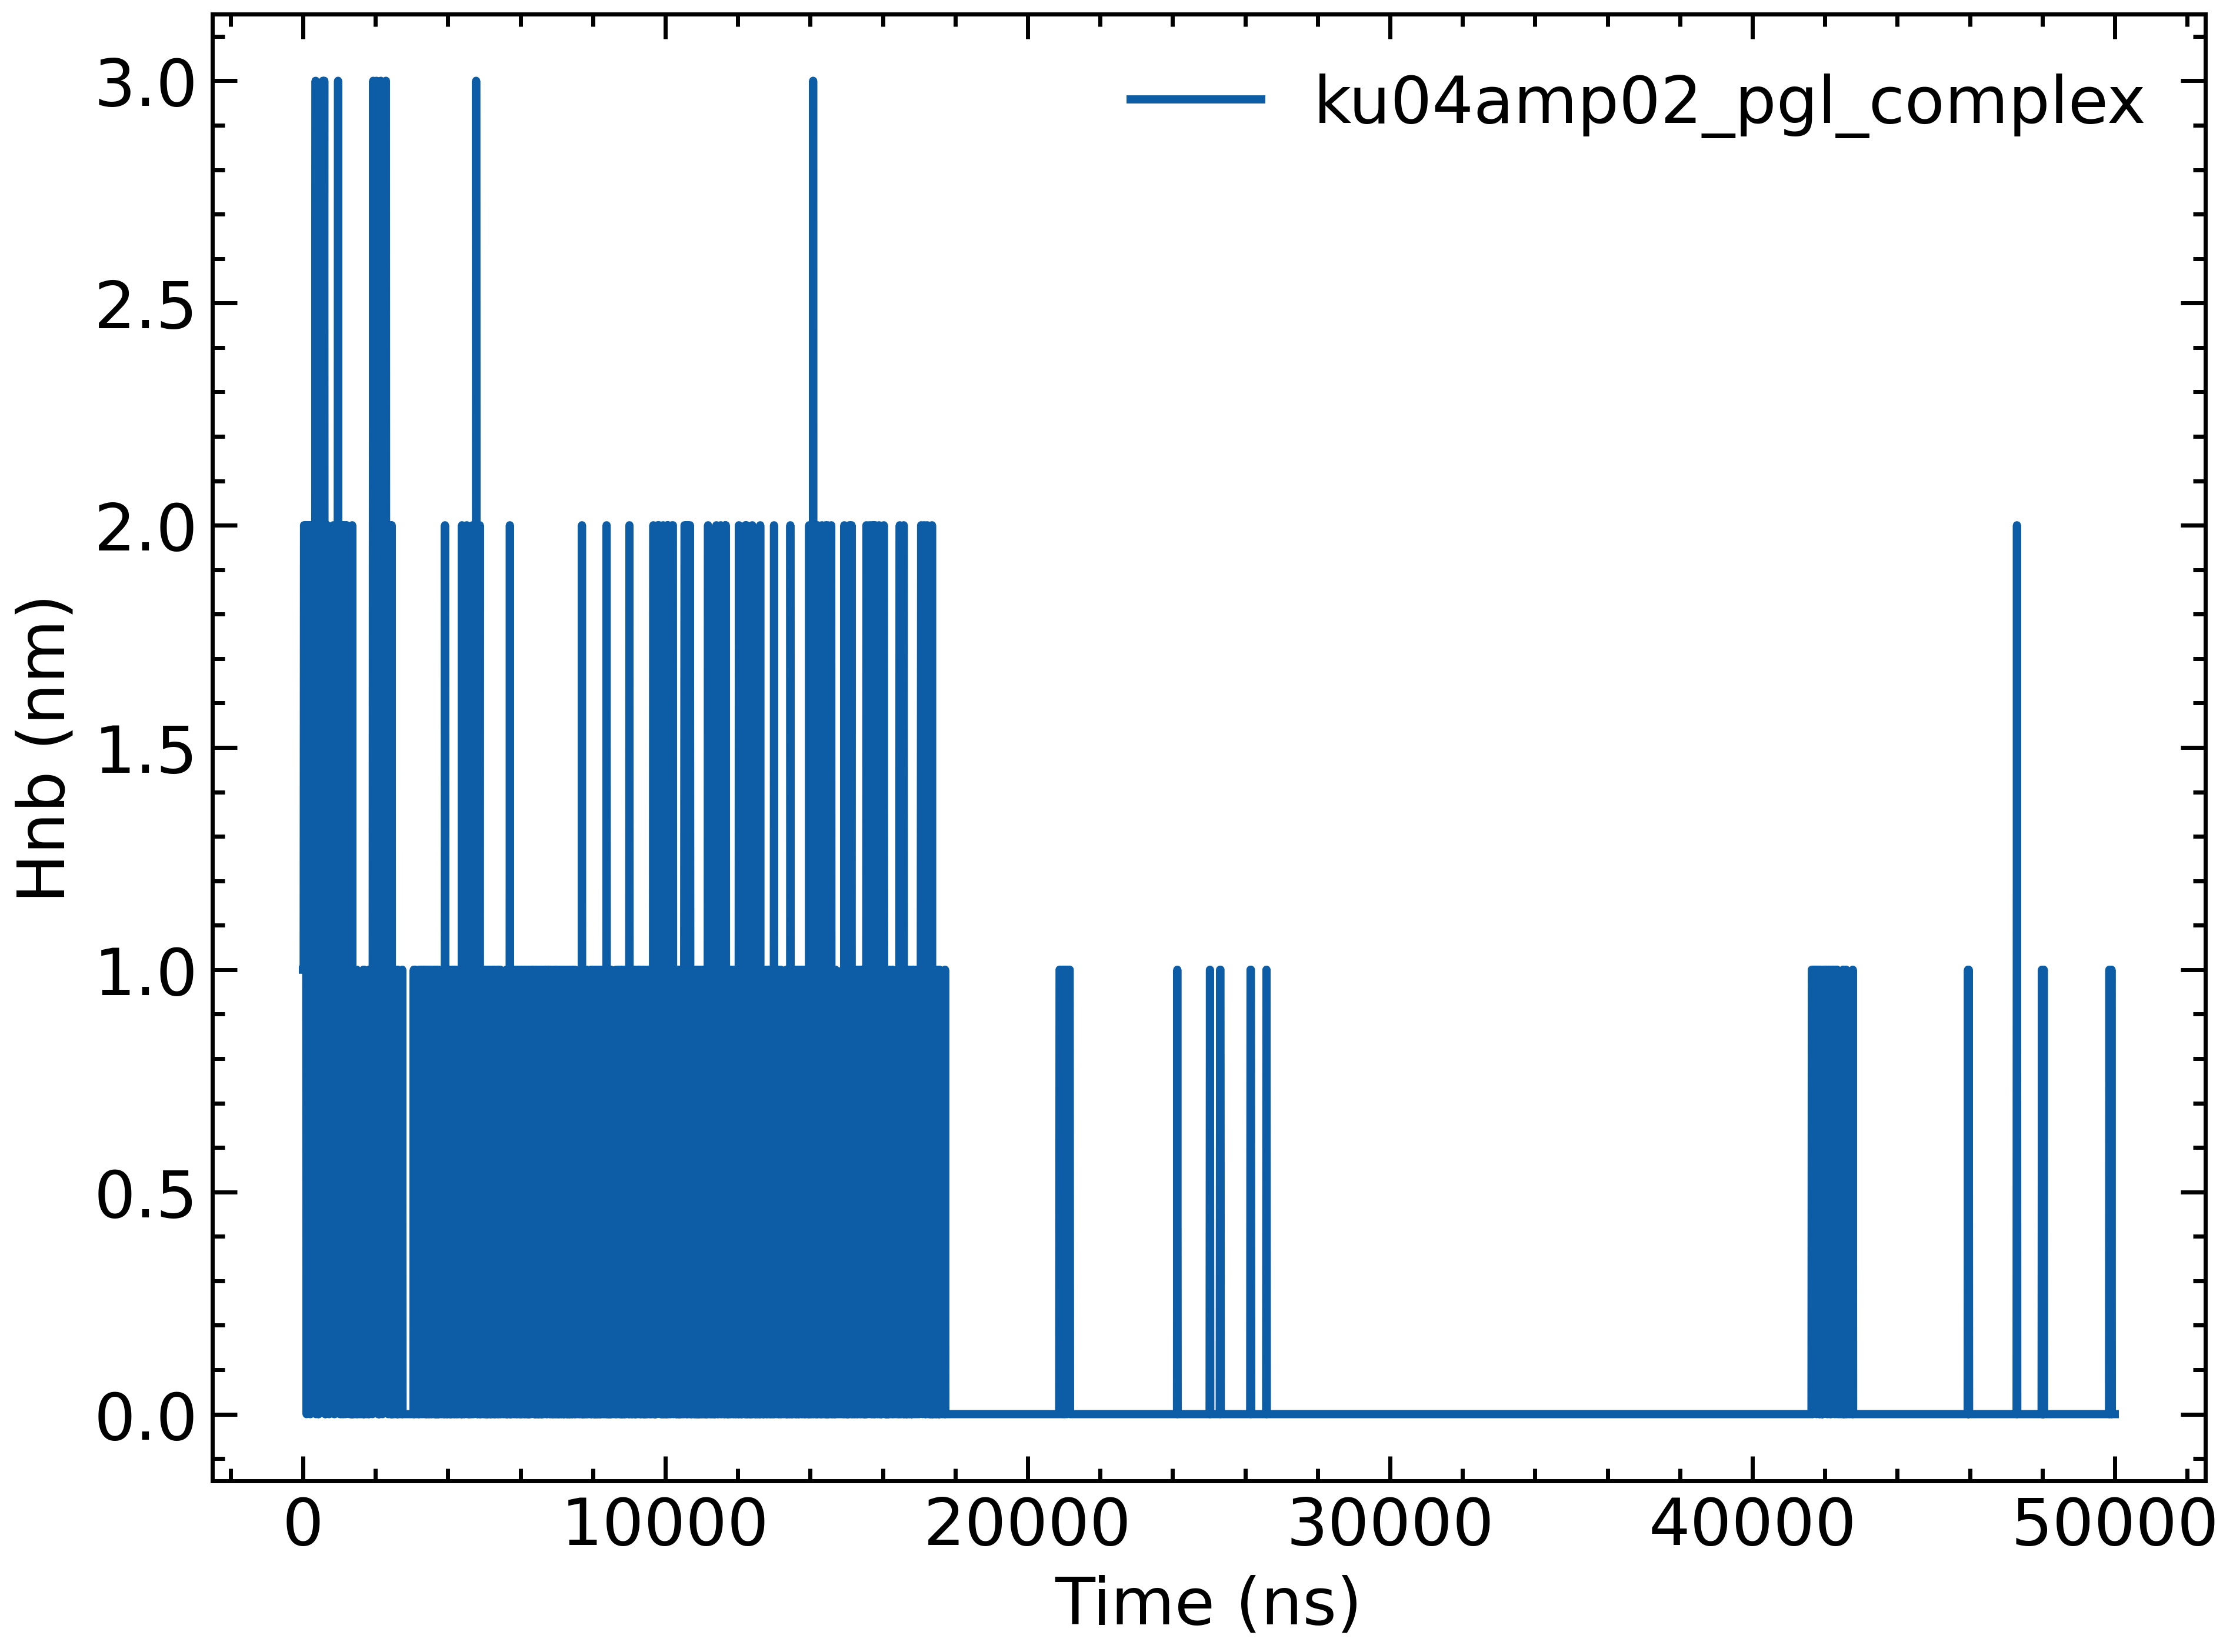

In [12]:
# Prepare and display the plot.
# Prepare and display the plot.
nhb_df.plot()
plt.xlabel('Time (ns)')
plt.ylabel('Hnb (nm)')
#plt.title('Nhb of all complexes')
lgd = plt.legend()
lgd.get_frame().set_alpha(0.2)
plt.show()

## Plots

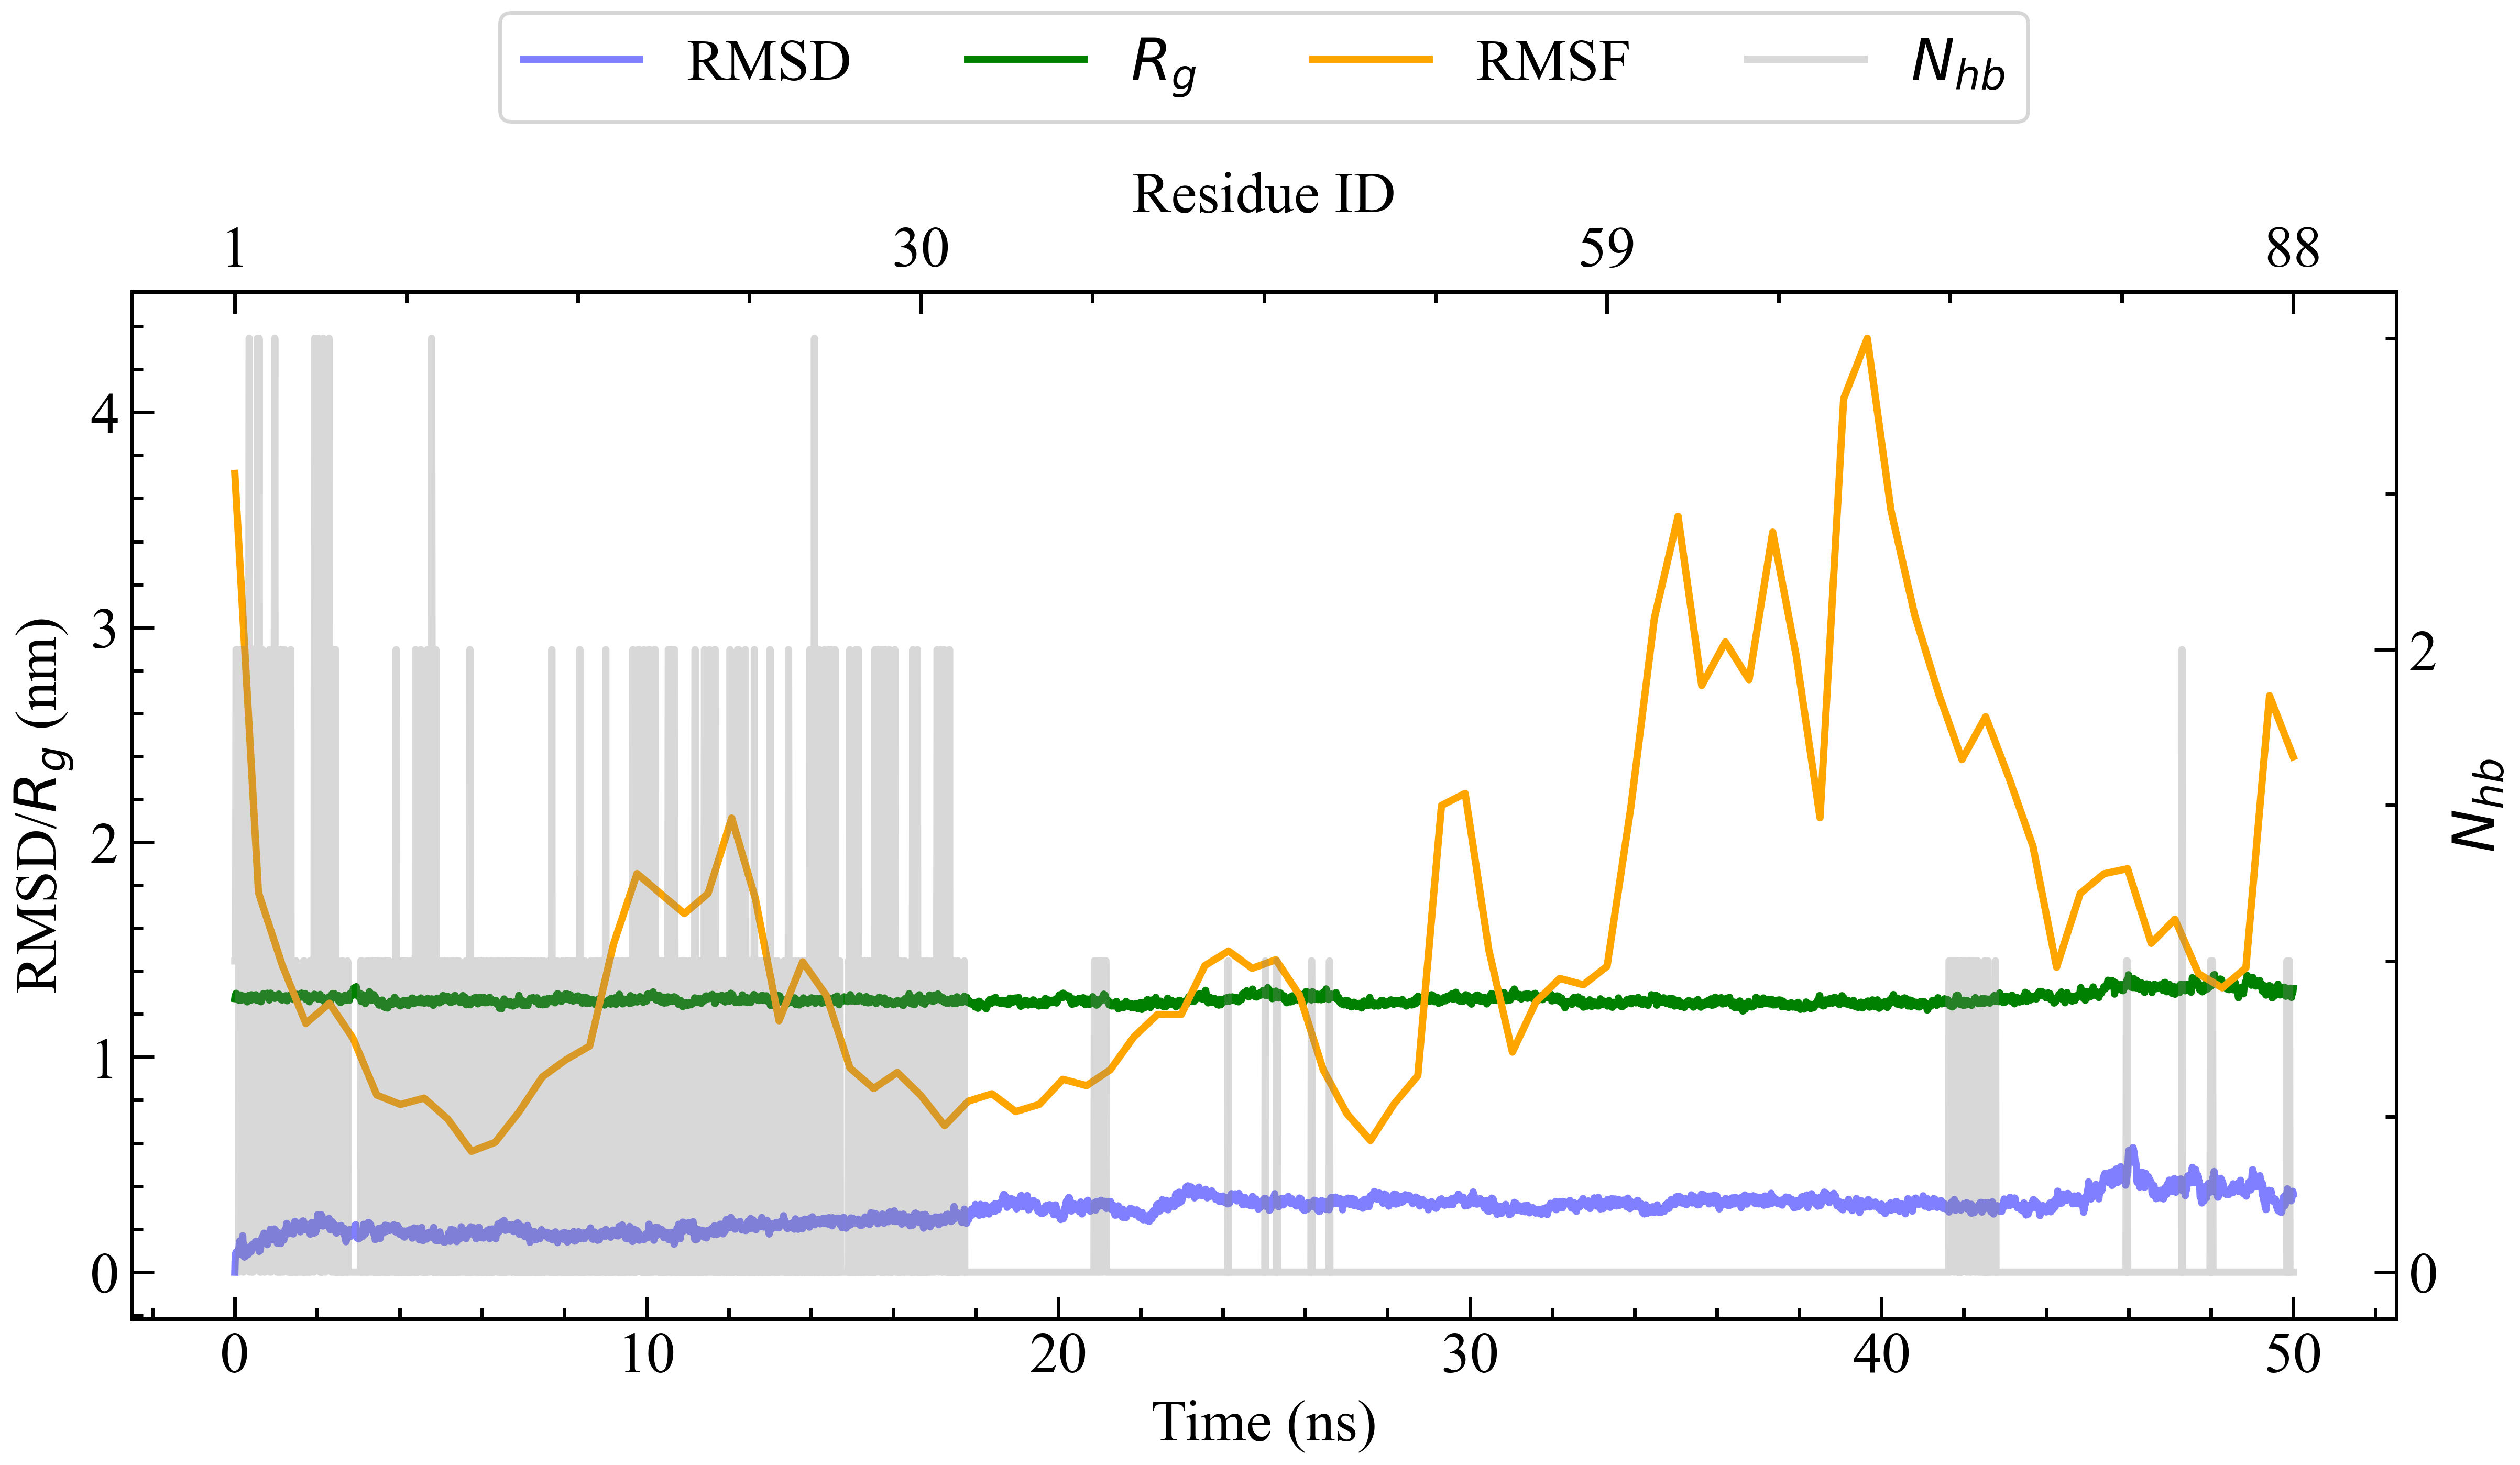

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import matplotlib

matplotlib.rcParams['axes.titlepad'] = 0
# Override the behavior of ax.axis('off') so that calls to turn off axes are ignored.
matplotlib.rcParams.update({'font.family': 'Times New Roman'})

fig, ax = plt.subplots(figsize=(10, 6), tight_layout=True)

ax.plot(times_c/1000, rmsd_c/10, alpha=0.5, label='RMSD', color='blue')
ax.plot(Rgyrc_table[:,1]/1000, Rgyrc_table[:,2]/10,label=r'$R_g$', color='green')

ax_top = ax.twiny()
ax_top.plot(c_alphas_c.resids, R_c.results.rmsf, label='RMSF', color='orange')
ticks = np.linspace(c_alphas_c.resids[0], c_alphas_c.resids[-1], 4)
ax_top.set_xticks(ticks)
ax_top.set_xticklabels(["{:.0f}".format(x) for x in ticks])
ax_right = ax.twinx()
ax_right.plot(nhb_df.index/1000, nhb_df['ku04amp02_pgl_complex'], label=r'$N_{hb}$', color='gray', alpha=0.3)
ymin, ymax = ax_right.get_ylim()
ticks = np.arange(0, np.ceil(ymax), 2)
ax_right.set_yticks(ticks)
ax_right.set_yticklabels(["{:.0f}".format(x) for x in ticks])

ax.set_xlabel('Time (ns)')
ax.set_ylabel(r'RMSD/$R_g$ (nm)')
ax_top.set_xlabel('Residue ID')
ax_right.set_ylabel(r'$N_{hb}$')
handles1, labels1 = ax.get_legend_handles_labels()
handles2, labels2 = ax_top.get_legend_handles_labels()
handles3, labels3 = ax_right.get_legend_handles_labels()
handles = handles1 + handles2 + handles3
labels = labels1 + labels2 + labels3
ax.legend(handles, labels, loc='upper center', bbox_to_anchor=(0.5, 1.3), ncol=4, frameon=True)
plt.savefig('ku04amp02_pgl_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

### Hydrogen Bond occupancy statistics

In [20]:
from tqdm.notebook import tqdm
hb_details = {}
u = ku04amp02_pgl
complex = 'ku04amp02_pgl_complex'
hb = hbs

ligand_indices = u.select_atoms('resname PGL').indices
hbstats = hb.count_by_ids()
# Only keep bonds with occupancy more than 1%
hbstats_filtered = hbstats[hbstats[:, -1] / hb.n_frames > 0.01]
bond_types = []
for bond in tqdm(hbstats_filtered):
    donor_idx, hydrogen_idx, acceptor_idx, occ = bond
    donor_atom = u.atoms[int(donor_idx)]
    hydrogen_atom = u.atoms[int(hydrogen_idx)]
    acceptor_atom = u.atoms[int(acceptor_idx)]
    # Check if the donor or acceptor is a ligand
    if donor_idx in ligand_indices and acceptor_idx not in ligand_indices:
        # Donor is a ligand, acceptor is not
        bond_type = f"({donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resid}-{acceptor_atom.resname}) : {occ/hb.n_frames:.2f}"
    elif acceptor_idx in ligand_indices and donor_idx not in ligand_indices:
        # Acceptor is a ligand, donor is not
        bond_type = f"({donor_atom.resid}-{donor_atom.resname}){donor_atom.name}-H::{acceptor_atom.name}({acceptor_atom.resname}) : {occ/hb.n_frames:.4f}"
    else:
        # Both donor and acceptor are ligands
        continue
    bond_types.append(bond_type)

  0%|          | 0/5 [00:00<?, ?it/s]

In [21]:
bond_types

['(PGL)N1-H::O(72-ALA) : 0.09',
 '(PGL)O5-H::O(86-VAL) : 0.02',
 '(PGL)N1-H::O(74-ARG) : 0.02',
 '(69-ASN)ND2-H::O5(PGL) : 0.0118',
 '(PGL)O5-H::OE1(16-GLN) : 0.01']

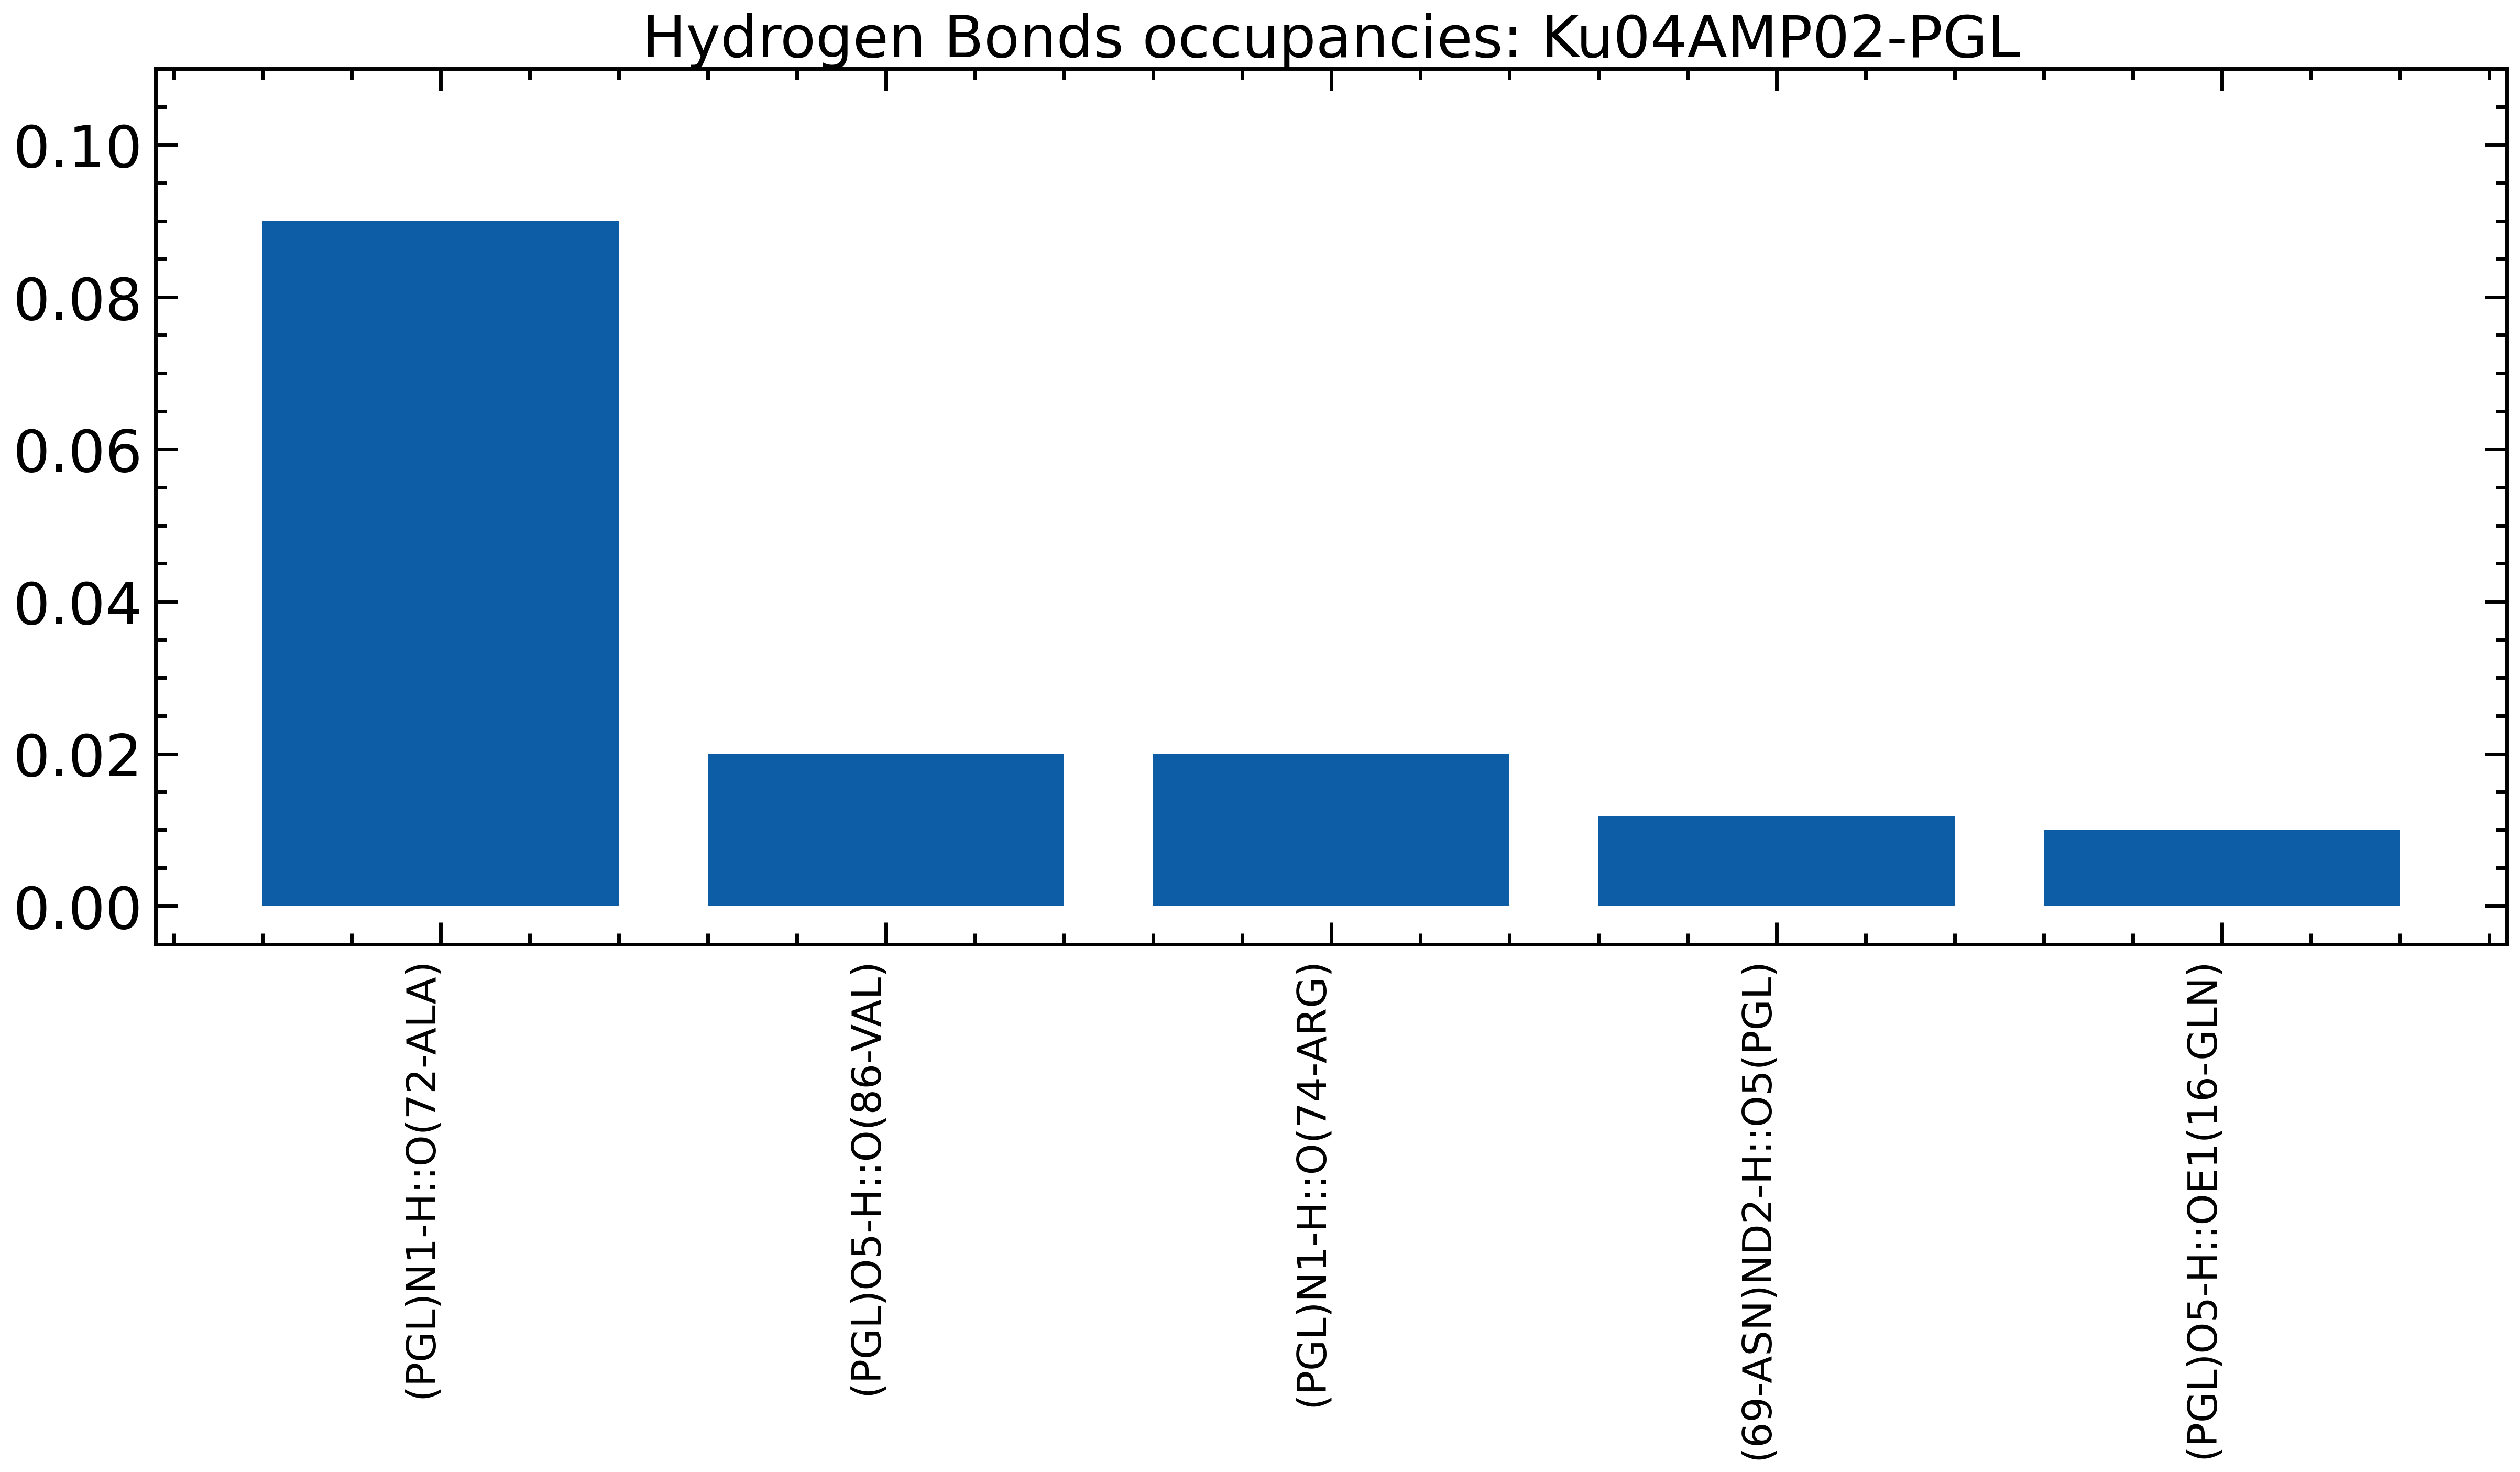

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import scienceplots
plt.style.use(['science', 'notebook'])
fig, ax = plt.subplots(figsize=(10, 6))
# Parse the bond_types to extract bond labels and occupancy values
labels = [b.split(" : ")[0] for b in bond_types]
occupancies = [float(b.split(" : ")[1]) for b in bond_types]

ax.bar(range(len(occupancies)), np.array(occupancies))
ax.set_xticks(range(len(occupancies)), labels, rotation=90, ha='right', fontsize=11)
ax.set_ylim(-0.005, 0.11);
plt.title('Hydrogen Bonds occupancies: Ku04AMP02-PGL');
plt.savefig('ku04amp02_pgl_hbond_occ.png', dpi=300, bbox_inches='tight')


## Principal Component Analysis (TODO)

We will do the PCA using `gromacs` tools. Tentative comparison yields quantitatively better results for `gromacs` than `MDAnalysis`.

***Notabene*** MUST USE BACKBONE AND LIGAND AS SELECTIONS, SINCE WE NEED TO LOOK AT LIGAND CONFORMATIONAL CHANGES AS WELL.


### PCA via GROMACS tools

Go to the `sys_prod` directory, then create an index for backbone, ligand 

`gmx make_ndx -f prod_colpk_pyc_complex.gro -o prod_colpk_pyc_complex_pca.ndx` Choose backbone OR PYC

Then, we need to dump the first frame of MD simulation as pdb file (unless that has already been done).

Then, generating the eigenvectors

`gmx covar -s start.pdb -f prod_colpk_pyc_complex_compact_compact.xtc -o prod_colpk_pyc_complex_eigenvalues.xvg -v prod_colpk_pyc_complex_eigenvectors.trr -xpma prod_colpk_pyc_complex_covapic.xpm -n prod_colpk_pyc_complex_pca.ndx`


Selections should be the index just created.

Followed by `gmx anaeig` to generate pc1, pc2 and pc3 files

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpk_pyc_complex_eigenvectors.trr -last 1 -proj prod_colpk_pyc_complex_pc1.xvg -n prod_colpk_pyc_complex_pca.ndx`

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -v prod_colpk_pyc_complex_eigenvectors.trr -first 2 -last 2 -proj prod_colpk_pyc_complex_pc2.xvg -n prod_colpk_pyc_complex_pca.ndx`

Use these three xvg files (`prod_colpk_pyc_complex_pc{1,2,3}.xvg`) to generate the following plots.

In [ ]:
import numpy as np

# Function to read XVG file with skip header option
def read_xvg(file_path, skip_header):
    data = []
    with open(file_path, 'r') as file:
        lines = file.readlines()
        for line in lines[skip_header:]:
            if '&' in line:
                break
            else:
                data.append([float(val) for val in line.split()])
    data = np.array(data)
    return data[:, 0], data[:, 1]

# File paths for RMSD and radius of gyration XVG files
pc1_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_pc1.xvg'
pc2_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_pc2.xvg'
pc3_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_pc3.xvg'

# Read data from XVG files with skip headers
t1, pc1_data = read_xvg(pc1_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc2_data = read_xvg(pc2_file, skip_header=24)  # Adjust skip_header based on your file format
t2, pc3_data = read_xvg(pc3_file, skip_header=24)  # Adjust skip_header based on your file format

In [ ]:
import matplotlib.pyplot as plt
import scienceplots
plt.style.use(['science','notebook'])
plt.plot(t1, pc1_data, label='PC1')
plt.plot(t2, pc2_data, label='PC2')
plt.plot(t2, pc3_data, label='PC3')
plt.xlabel('Time (ps)')
plt.ylabel('Principal Component')
plt.legend()

For PCA with respect to energy, first

```bash
paste prod_colpk_pyc_complex_pc1.xvg prod_colpk_pyc_complex_pc2.xvg | awk '{print $1, $2, $4}' > prod_colpk_pyc_complex_pc1pc2.xvg

paste prod_colpk_pyc_complex_pc2.xvg prod_colpk_pyc_complex_pc3.xvg | awk '{print $1, $2, $4}' > prod_colpk_pyc_complex_pc2pc3.xvg

paste prod_colpk_pyc_complex_pc3.xvg prod_colpk_pyc_complex_pc1.xvg | awk '{print $1, $2, $4}' > prod_colpk_pyc_complex_pc3pc1.xvg
```

Then, use these PCIPCJ.xvg files to generate xpm files

```bash

gmx sham -f prod_colpk_pyc_complex_pc1pc2.xvg -ls prod_colpk_pyc_complex_FES12.xpm
gmx sham -f prod_colpk_pyc_complex_pc2pc3.xvg -ls prod_colpk_pyc_complex_FES23.xpm
gmx sham -f prod_colpk_pyc_complex_pc3pc1.xvg -ls prod_colpk_pyc_complex_FES32.xpm

```

Then use the following `xpm2txt.py` script to convert the .xpm file into .dat file:


In [ ]:
%%script true
#!/usr/bin/env python3

import sys

"""
Utility tool to convert xpm files generated by GROMACS to a 3-column text file.
"""

USAGE = "USAGE: xpm2txt.py -f <input xpm file> -o <output txt file> [-s]\n"
USAGE += "Options:\n"
USAGE += "\t-s\t(int)\tSorts the output by a given column"
USAGE += "\n"  # always keep this line

# Parse arguments
read_input, read_output, sort = False, False, False
xpm_file, out_file, column_sort = None, None, None
for arg in sys.argv[1:]:
    if read_input:
        read_input = False
        xpm_file = arg
    elif read_output:
        read_output = False
        out_file = arg
    elif sort:
        sort = False
        column_sort = int(arg)
    if arg.startswith("-"):
        if arg == "-f":
            read_input = True
            continue
        elif arg == "-o":
            read_output = True
            continue
        elif arg == "-s":
            sort = True
        else:
            print(USAGE)
            sys.stderr.write('ERROR: Option not recognized: %s\n' % arg)
            sys.exit(1)

if not xpm_file:
    print(USAGE)
    sys.stderr.write('ERROR: You forgot to provide an input file.\n')
    sys.exit(1)
if not out_file:
    out_file = "out.txt"

# Parse XPM file
with open(xpm_file) as xpm_handle:
    xpm_data = []
    x_axis, y_axis = [], []
    letter_to_value = {}
    for line in xpm_handle:
        if line.startswith("/* x-axis"):
            x_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith("/* y-axis"):
            y_axis = list(map(float, line.split()[2:-2]))  # We trim the last value

        if line.startswith('"') and x_axis and y_axis:  # Read data
            xpm_data.insert(0, line.strip().strip(',')[1:-1])

        if line.startswith('"') and len(line.split()) > 4:
            letter = line.split()[0][1:]
            value = float(line.split()[-2][1:-1])
            letter_to_value[letter] = value

# Match x/y/data
txt_values = []
for y_index, data_value in enumerate(xpm_data):
    y_value = y_axis[y_index]
    for x_index, x_value in enumerate(x_axis):
        txt_values.append([x_value, y_value, letter_to_value[data_value[x_index]]])

# Apply sorting if requested
if column_sort:
    try:
        txt_values.sort(key=lambda x: x[column_sort - 1])
    except IndexError:
        print(USAGE)
        sys.stderr.write('ERROR: Column not found (%s)\n' % (column_sort))
        sys.exit(1)

# Print to file
with open(out_file, 'w') as out_handle:
    for x, y, z in txt_values:
        out_handle.write("%3.5f\t%3.5f\t%3.5f\n" % (x, y, z))

Use this above-mentioned script as

```bash
./xpm2txt.py -f prod_colpk_pyc_complex_FES12.xpm -o prod_colpk_pyc_complex_FEL12.dat
./xpm2txt.py -f prod_colpk_pyc_complex_FES23.xpm -o prod_colpk_pyc_complex_FEL23.dat
./xpm2txt.py -f prod_colpk_pyc_complex_FES31.xpm -o prod_colpk_pyc_complex_FEL31.dat
```

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Read input data from a file
input_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_FEL12.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC12_1 = data[:, 0]
PC12_2 = data[:, 1]
free_energy_12 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol


input_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_FEL23.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC23_2 = data[:, 0]
PC23_3 = data[:, 1]
free_energy_23 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol

input_file = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_FEL31.dat'
data = np.loadtxt(input_file)  # Assuming input data file ha6s PC1, PC2, and hbonds columns

PC31_3 = data[:, 0]
PC31_1 = data[:, 1]
free_energy_31 = data[:, 2]/4.184  # Convert kJ/mol to kcal/mol


# Function to read XVG file and extract data
def read_xvg(file_path):
    data = np.genfromtxt(file_path, skip_header=18)  # Adjust skip_header based on your XVG file format
    xpoints = data[:, 0]
    ypoints = data[:, 1]
    return xpoints, ypoints

# Replace these placeholders with your actual file paths
D1_path = 'colpk_pyc_complex/sys_prod/prod_colpk_pyc_complex_eigenvalues.xvg'

# Read data from XVG files
time_D1, D1_data = read_xvg(D1_path)

plt.plot(time_D1[0:50], D1_data[0:50], color='red')
plt.xlim(1, )
plt.ylim(0, )
plt.xlabel('Eigenvector index')
plt.ylabel(r'Variance $\left(nm^2\right)$')
plt.title('PCA of ColPk-PYC');
plt.savefig("pca-colpk-pyc.png", dpi=600)


In [ ]:
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import scienceplots
import matplotlib.pyplot as plt

size = np.array([40,14])

plt.style.use(['science','notebook'])
fig = plt.figure(figsize=size)
fig.suptitle(r'PCA: Free Energy Landscapes $\left(kcal\cdot mol^{-1}\right)$', fontsize=20)
# First subplot: free_energy_12 vs PC12
ax1 = fig.add_subplot(1, 3, 1, projection='3d')
ax1.plot_trisurf(PC12_1, PC12_2, free_energy_12, cmap='viridis', alpha=0.8)
ax1.set_xlabel(r'$PC_1\; (nm)$', labelpad=20)
ax1.set_ylabel(r'$PC_2\;(nm)$', labelpad=20)
ax1.scatter(PC12_1, PC12_2, c=free_energy_12, cmap='viridis', s=50, alpha=0.5)
ax1.scatter(pc1_data[0:200], pc2_data[0:200], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax1.scatter(pc1_data[-1000:-1], pc2_data[-1000:-1], 0, color='red', linewidth=4, label='Trajectory End')
ax1.legend()

# Second subplot: free_energy_23 vs PC23
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
ax2.plot_trisurf(PC23_2, PC23_3, free_energy_23, cmap='viridis', alpha=0.8)
ax2.set_xlabel(r'$PC_2\; (nm)$', labelpad=20)
ax2.set_ylabel(r'$PC_3\; (nm)$', labelpad=20)
ax2.scatter(PC23_2, PC23_3, c=free_energy_23, cmap='viridis', s=50, alpha=0.5)
ax2.scatter(pc2_data[0:30], pc3_data[0:30], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax2.scatter(pc2_data[-500:-1], pc3_data[-500:-1], 0, color='red', linewidth=4, label='Trajectory End')

# Third subplot: free_energy_31 vs PC31
ax3 = fig.add_subplot(1, 3, 3, projection='3d')
ax3.plot_trisurf(PC31_1, PC31_3, free_energy_31, cmap='viridis', alpha=0.8)
ax3.set_xlabel(r'$PC_3\; (nm)$', labelpad=20)
ax3.set_ylabel(r'$PC_1\; (nm)$', labelpad=20)
ax3.scatter(PC31_1, PC31_3, c=free_energy_31, cmap='viridis', s=50, alpha=0.5)
ax3.scatter(pc1_data[0:100], pc3_data[0:100], 0, color='magenta', linewidth=4, label='Trajectory Start')
ax3.scatter(pc1_data[-1000:-1], pc3_data[-1000:-1], 0, color='red', linewidth=4, label='Trajectory End')

for ax in [ax1, ax2, ax3]:
    ax.view_init(elev=15, azim=80)
    ax.yaxis.set_tick_params(pad=10)

ax1.zaxis.set_tick_params(pad=10)
ax2.set_zticklabels([])
ax3.set_zticklabels([])
plt.savefig("pca-free-energy.svg", dpi=600)
plt.tight_layout()
plt.show()

### PCA Conclusion

The PCA reveals complex free energy landscape. The trajectory appears to start inside a free energy valley in the $PC_1-PC_2-PC_3$ space, but then undergoes thermal transition to the final global minimum. However, the lack of hbonds between pyc and protein indicates that this transition is due to conformational shifts instead, and will probably occur due to protein folding regardless of the pyc.


Finally, I ran the following commands to project the trajectory to the PCA components and then visualize them.

`gmx anaeig -f prod_colpk_pyc_complex_compact_compact.xtc -s start.pdb -extr extreme_pc.pdb -first 1 -last 3 -n prod_colpk_pyc_complex_pca.ndx -nframes 80 -v prod_colpk_pyc_complex_eigenvectors.trr`

Then load the three pdbs of the projetions along each axis into pymol and made the following observations. Along all projections, the tail beginning of the protein seems to 'whip about' a bit, suggesting a possible **conformational change** that might cause the shifts from one valley to another in the free energy landscape above.


In [ ]:
from IPython.display import Image
Image("pc1pc2pc3.png")